[26_01_22_과제]
- 알파벳을 사용하는 언어는 알파벳 빈도의 차이로 언어를 식별할 수 있습니다.
- 해당 데이터셋을 활용해서 언어 식별 모델을 생성하세요.
- 데이터셋
  * train 폴더 =>  나라영문2글자-숫자.txt
  * test 폴더  =>  나라영문2글자-숫자.txt

- 데이터셋 부족 시 Wikipedia 사이트에서 추가 가능 합니다.

[0] txt -> csv 변환 <hr>
문장들의 알파벳 별 빈도수 즉 비율로 csv 파일 저장

In [437]:
# from txt_csv import *
# csv_data('./dataset/train/', 'train.csv')
# csv_data('./dataset/test/', 'test.csv')

[1] 모듈 로딩 및 데이터 준비 <hr>

In [438]:
# ================================================================================
# [1-1] 모듈 로딩
# ================================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import util_func as uf 

# ================================================================================
# [1-2] 데이터 준비
# ================================================================================
trainDF = pd.read_csv("./dataset/train.csv")
testDF = pd.read_csv("./dataset/test.csv")

display(trainDF.head())
print(f"Train shape: {trainDF.shape}, Test shape: {testDF.shape}")

,filename,language,a,b,c,d,e,f,g,h,...,q,r,s,t,u,v,w,x,y,z
0,en-1.txt,en,0.0760,0.0128,0.0457,0.0461,0.1053,0.0157,0.0192,0.0437,...,0.0000,0.0777,0.0614,0.0805,0.0259,0.0098,0.0141,0.0007,0.0200,0.0004
1,en-2.txt,en,0.0840,0.0199,0.0303,0.0388,0.1367,0.0174,0.0312,0.0274,...,0.0055,0.0899,0.0715,0.0776,0.0306,0.0137,0.0139,0.0020,0.0107,0.0006
2,en-3.txt,en,0.0716,0.0122,0.0456,0.0326,0.1201,0.0147,0.0252,0.0235,...,0.0017,0.0539,0.0880,0.0811,0.0290,0.0188,0.0119,0.0006,0.0180,0.0006
3,en-4.txt,en,0.0720,0.0276,0.0299,0.0395,0.1207,0.0167,0.0235,0.0588,...,0.0004,0.0590,0.0731,0.0934,0.0242,0.0051,0.0195,0.0060,0.0175,0.0017
4,en-5.txt,en,0.0738,0.0204,0.0311,0.0396,0.1413,0.0204,0.0204,0.0569,...,0.0004,0.0725,0.0596,0.0955,0.0250,0.0107,0.0239,0.0031,0.0149,0.0007


Train shape: (20, 28), Test shape: (8, 28)


[2] 커스텀 Dataset 클래스 <hr>

In [439]:
# ================================================================================
# [2-1] 커스텀 데이터셋 클래스 정의
# ================================================================================
# 클래스이름 : LangDataset
# 부모클래스 : Dataset
# 오버라이딩 : __init__()
#            __len__()
#            __getitem__()
# ================================================================================
class LangDataset(Dataset):
    
    def __init__(self, dataDF):
        super().__init__()

        self.x = dataDF[dataDF.columns[2:]].values  # 피쳐

        targetDict = {"en":0, "fr":1, "id":2, "tl":3}
        self.y = dataDF[dataDF.columns[1]].map(targetDict).values.astype(np.int64)
        # self.y = dataDF[dataDF.columns[1]].values   # 타겟

    def __len__(self):
        return self.x.shape[0] # 행수
    
    # 인덱스에 해당하는 피쳐와 타겟 텐서 반환 메서드
    def __getitem__(self, index):
        xTS = torch.tensor(self.x[index], dtype = torch.float32)
        yTS = torch.tensor(self.y[index])

        return xTS, yTS

In [440]:
# ================================================================================
# [2-2] 커스텀 데이터셋 인스턴스 생성 및 사용
# ================================================================================
allDS  = LangDataset(trainDF)
testDS = LangDataset(testDF)

print(f"allDS : {len(allDS)}, testDS : {len(testDS)}")

allDS : 20, testDS : 8


In [441]:
# ================================================================================
# [2-3] 학습용/검증용/테스트용 데이터셋 분리
# ================================================================================
# 학습용 데이터셋에서 타겟/라벨만 추출 
targetList = allDS.y

# 전체 데이터 인덱스 리스트 생성
dataIndexList = list(range(len(allDS)))

# 학습용/검증용 데이터셋 인덱스 분리
x_trainIdx, x_validIdx, y_train, y_valid = train_test_split(
    dataIndexList,
    targetList,
    stratify=targetList,
    train_size=0.8,
    random_state=10)

In [442]:
# ================================================================================
# [2-4] 학습용/검증용 데이터셋 생성 ===> Dataset ==> 2개 Subset 분리
# ================================================================================
trainDS = Subset(allDS, x_trainIdx)
validDS = Subset(allDS, x_validIdx)

print(f"allDS : {len(allDS)}, trainDS : {len(trainDS)}, validDS : {len(validDS)}, testDS : {len(testDS)}")

allDS : 20, trainDS : 16, validDS : 4, testDS : 8


[3] 모델 클래스 설계 <hr>

In [443]:
# ================================================================================
# [3-1] 커스텀 모델 클래스 정의
# ================================================================================
#               입력                출력               활성화함수
# 입력층          26                 26                 
# 은닉층1         26                128                  ReLU
# 은닉층2        128                 64                  ReLU
# 은닉층3         64                 32                  ReLU
# 출력층          32                  1                   -      Pytorch의 다중분류 손실함수 중
#                                                               CrossEntropyLoss는 내부에서 softmax 처리 진행
#                                                               출력층에서 softmax 활성함수 필요 없음!
# ================================================================================
# 클래스이름 : LangModel
# 부모클래스 : nn.module
# 오버라이딩 : __init()
#            forward()
# ================================================================================
class LangModel(nn.Module):

    def __init__(self, in_, out_, hd1, hd2, hd3):
        
        # 인공신경망(ANN) 구성
        super().__init__()
        self.hd1_layer = nn.Linear(in_, hd1)
        self.hd2_layer = nn.Linear(hd1, hd2)
        self.hd3_layer = nn.Linear(hd2, hd3)
        self.out_layer = nn.Linear(hd3, out_)

    def forward(self, data):

        # 입력층  -> 은닉층1
        out = F.relu(self.hd1_layer(data))

        # 은닉층1 -> 은닉층2
        out = F.relu(self.hd2_layer(out))

        # 은닉층2 -> 은닉층3
        out = F.relu(self.hd3_layer(out))

        # 은닉층3 -> 출력층
        out = self.out_layer(out)

        return out

In [444]:
# ================================================================================
# [3-2] 커스텀 모델 클래스 구조 확인
# ================================================================================
from torchinfo import summary
summary(LangModel(in_=26, out_=4, hd1=128, hd2=64, hd3=32),
        input_size=(1, 26))

Layer (type:depth-idx)                   Output Shape              Param #
LangModel                                [1, 4]                    --
├─Linear: 1-1                            [1, 128]                  3,456
├─Linear: 1-2                            [1, 64]                   8,256
├─Linear: 1-3                            [1, 32]                   2,080
├─Linear: 1-4                            [1, 4]                    132
Total params: 13,924
Trainable params: 13,924
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

[4] 학습 준비<hr>

In [445]:
# ================================================================================
# [4-1] 학습 관련 설정
# ================================================================================
EPOCHS      = 100
BATCH_SIZE  = 2
LR          = 0.01
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

In [446]:
# ================================================================================
# [4-2] 학습 관련 인스턴스 생성
# ================================================================================
# 모델 인스턴스
model = LangModel(in_=26, out_=4, hd1=128, hd2=64, hd3=32).to(DEVICE)

# 손실함수 인스턴스 : 다중분류용
lossFN = nn.CrossEntropyLoss()

# 최적화 인스턴스
optimizer = optim.Adam(model.parameters(), lr=LR)

# 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
validDL = DataLoader(validDS, batch_size=BATCH_SIZE)
testDL = DataLoader(testDS, batch_size=BATCH_SIZE)

[5] 학습 진행 <HR>

In [447]:
HISTORY = {
    'train_loss': [],       # 학습 손실값 (작을수록 좋음)
    'train_acc' : [],       # 학습 정확도 (클수록 좋음)
    'val_loss'  : [],       # 검증 손실값 (작을수록 좋음)
    'val_acc'   : []        # 검증 정확도 (클수록 좋음)
}

for epoch in range(EPOCHS):
    # 1에포크 학습
    train_loss, train_acc = uf.train_one_epoch(
        model, 
        trainDL, 
        lossFN, 
        optimizer,
        DEVICE)

    # 1에포크 학습 후 업데이트 W, b 검사
    val_loss, val_acc = uf.evaluate(model, validDL, lossFN, DEVICE)

    # 학습과 검증 결과 저장 
    HISTORY['train_loss'].append(train_loss)
    HISTORY['train_acc'].append(train_acc)
    HISTORY['val_loss'].append(val_loss)
    HISTORY['val_acc'].append(val_acc)


    # 진행 상황 출력
    print( f'[EPOCH-{epoch:03}] LOSS => Train : {train_loss:.7f}  Valid : {val_loss:.7f}  Acc => Train : {train_acc:.5f}' , end='')
    print( f'  Valid : {val_acc:.5f}' )

[EPOCH-000] LOSS => Train : 1.4261493  Valid : 1.3883697  Acc => Train : 0.18750  Valid : 0.25000
[EPOCH-001] LOSS => Train : 1.3954329  Valid : 1.3883221  Acc => Train : 0.25000  Valid : 0.25000
[EPOCH-002] LOSS => Train : 1.3905839  Valid : 1.3874298  Acc => Train : 0.25000  Valid : 0.25000
[EPOCH-003] LOSS => Train : 1.3905529  Valid : 1.3868575  Acc => Train : 0.12500  Valid : 0.25000
[EPOCH-004] LOSS => Train : 1.3899816  Valid : 1.3856635  Acc => Train : 0.12500  Valid : 0.25000
[EPOCH-005] LOSS => Train : 1.3952924  Valid : 1.3844776  Acc => Train : 0.12500  Valid : 0.25000
[EPOCH-006] LOSS => Train : 1.3875628  Valid : 1.3830166  Acc => Train : 0.12500  Valid : 0.25000
[EPOCH-007] LOSS => Train : 1.3846449  Valid : 1.3781849  Acc => Train : 0.25000  Valid : 0.25000
[EPOCH-008] LOSS => Train : 1.3748786  Valid : 1.3553484  Acc => Train : 0.25000  Valid : 0.75000
[EPOCH-009] LOSS => Train : 1.3643704  Valid : 1.2958326  Acc => Train : 0.37500  Valid : 0.50000
[EPOCH-010] LOSS => 

[6] 시각화 <hr>

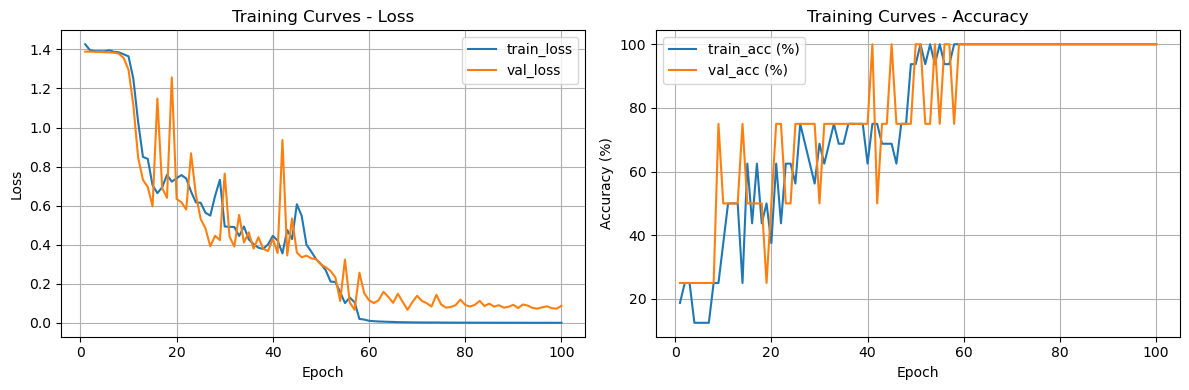

In [448]:
uf.plot_history(HISTORY)